# Build Graph by BERT


- node: the embeddings of the content (BERT)
- edge: the similarity between the nodes (KNN)

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load the dataset

In [7]:
from datasets import load_dataset

/home/littlefish/miniconda3/envs/fakenews/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# load and download the dataset from huggingface
dataset = load_dataset("LittleFish-Coder/Fake-News-Detection-Challenge-KDD-2020", download_mode="reuse_cache_if_exists", cache_dir="dataset")

Generating test split: 100%|██████████| 499/499 [00:00<00:00, 26000.77 examples/s]


In [9]:
print(f"Dataset Type: {type(dataset)}")
print(f"{dataset}")
print(f"Dataset keys: {dataset.keys()}")

Dataset Type: <class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 3490
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 997
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 499
    })
})
Dataset keys: dict_keys(['train', 'validation', 'test'])


In [10]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]
print(f"Train dataset type: {type(train_dataset)}")
print(f"Validation dataset type: {type(val_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")

Train dataset type: <class 'datasets.arrow_dataset.Dataset'>
Validation dataset type: <class 'datasets.arrow_dataset.Dataset'>
Test dataset type: <class 'datasets.arrow_dataset.Dataset'>


In [11]:
# First element of the train dataset
print(f"{train_dataset[0].keys()}")
print(f"Text: {train_dataset[0]['text']}")
print(f"Label: {train_dataset[0]['label']}")

dict_keys(['text', 'label', '__index_level_0__'])
Text: UPDATE, WRITETHRU with more detail: Shortly before he was due to appear on ITV’s Good Morning Britain today, Ewan McGregor pulled out of the interview, citing comments made about this weekend’s Women’s March by host Piers Morgan. A supporter of President Donald Trump, Morgan yesterday on the program described some of the women who marched as “rabid feminists” and said he didn’t “see the point of the march(es)” which he called “generic” and “vacuous.”  On Twitter this morning, McGregor, who is out promoting Trainspotting sequel T2: Trainspotting, wrote, “Was going on Good Morning Britain, didn’t realise Piers Morgan was host. Won’t go on with him after his comments about #WomensMarch.”  Was going on Good Morning Britain, didn’t realise @piersmorgan was host. Won’t go on with him after his comments about #WomensMarch — Ewan McGregor (@mcgregor_ewan) January 24, 2017  On his Twitter account (whose timeline photo is of he and Trump), 

# Load Tokenizer and Model

In [12]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(f"google-bert/bert-base-uncased", clean_up_tokenization_spaces=True)
model = AutoModel.from_pretrained(f"google-bert/bert-base-uncased").to(device)

In [13]:
# tokenize the first train dataset
inputs = tokenizer(train_dataset[0]['text'], return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
print(f"Input keys: {inputs.keys()}")
print(f"Input ids: {inputs['input_ids']}")
print(f"Attention mask: {inputs['attention_mask']}")

Input keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Input ids: tensor([[  101, 10651,  1010,  4339,  2705,  6820,  2007,  2062,  6987,  1024,
          3859,  2077,  2002,  2001,  2349,  2000,  3711,  2006, 11858,  1521,
          1055,  2204,  2851,  3725,  2651,  1010,  1041,  7447, 23023,  2766,
          2041,  1997,  1996,  4357,  1010,  8951,  7928,  2081,  2055,  2023,
          5353,  1521,  1055,  2308,  1521,  1055,  2233,  2011,  3677, 16067,
          5253,  1012,  1037, 10129,  1997,  2343,  6221,  8398,  1010,  5253,
          7483,  2006,  1996,  2565,  2649,  2070,  1997,  1996,  2308,  2040,
          9847,  2004,  1523, 10958, 17062, 10469,  2015,  1524,  1998,  2056,
          2002,  2134,  1521,  1056,  1523,  2156,  1996,  2391,  1997,  1996,
          2233,  1006,  9686,  1007,  1524,  2029,  2002,  2170,  1523, 12391,
          1524,  1998,  1523, 12436, 10841,  3560,  1012,  1524,  2006, 10474,
          2023,  2851,  1010, 23023,  1010,  20

## Get the embeddings of the content

In [14]:
model.config.output_hidden_states = True

# Get model output with hidden states
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**inputs)

# Now, outputs will have the hidden states
hidden_states = outputs.hidden_states

# The last layer's hidden state can be accessed like this
last_hidden_state = outputs.last_hidden_state

# take the mean of the last hidden state
embeddings = last_hidden_state.mean(dim=1)

In [15]:
# Let's check the shape of the last hidden state
print(f"There are {len(hidden_states)} hidden states")
print(f"Shape of the last hidden state: {last_hidden_state.shape}")

There are 13 hidden states
Shape of the last hidden state: torch.Size([1, 512, 768])


In [16]:
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings: \n{embeddings}")

Embeddings shape: torch.Size([1, 768])
Embeddings: 
tensor([[-2.5972e-02, -1.0488e-01,  3.3387e-01, -1.6336e-01,  8.4529e-02,
         -4.0408e-02,  1.7998e-01,  3.9875e-01,  1.0262e-01,  1.0095e-01,
         -1.0618e-02, -3.5125e-01, -2.3232e-01,  2.3050e-01, -8.4879e-02,
          4.8300e-01,  6.0474e-02,  6.9526e-02, -2.3808e-01,  2.1106e-01,
          4.4448e-01,  3.0798e-02,  1.2963e-01,  3.8113e-01,  5.4776e-01,
          1.5527e-02,  6.9571e-02, -2.3551e-01, -3.5181e-01, -3.1960e-02,
          4.5161e-01,  6.6490e-03, -9.4695e-02, -1.6000e-01, -4.8676e-02,
         -1.4999e-01, -5.0338e-02, -1.4458e-01,  3.4407e-02,  1.4660e-01,
         -6.2394e-01, -2.9785e-01, -2.6331e-02,  1.7596e-01, -2.5245e-01,
         -1.2941e-01,  5.2772e-01,  2.0939e-01,  4.4239e-02, -3.5518e-02,
         -2.0509e-01,  5.1960e-01,  1.9304e-01, -7.7366e-02,  1.2713e-01,
          3.9100e-01, -1.7471e-01, -5.9035e-01, -4.1179e-01, -3.2222e-01,
          1.8764e-01,  1.3571e-01,  4.9532e-02, -3.7943e-01,

# Create Class Model

Now that we know how to get the embeddings of the content, 

we can create a class model that will take the dataset and get the embeddings of the content.

In [17]:
print(type(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [40]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel
class CustomDataset(Dataset):
    def __init__(self, texts, labels, size=None, model_name='bert-base-uncased', max_length=512):
        if size is not None and size < len(texts):
            self.texts = texts[:size]
            self.labels = labels[:size]
        else:
            self.texts = texts
            self.labels = labels
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        inputs = self.tokenizer(text, padding=True, truncation=True, max_length=self.max_length, return_tensors='pt')
        # Move inputs to CUDA
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Get the BERT embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            embeddings = last_hidden_state.mean(dim=1)  # [1, 768]
            # flatten the embeddings
            embeddings = embeddings.flatten()  # [768]
            # print(f"Embeddings shape: {embeddings.shape}")

        # put the embeddings into cpu
        embeddings = embeddings.cpu()

        return embeddings, label


In [59]:
TRAIN_SIZE = 200
VAL_SIZE = 100
TEST_SIZE = 100

embeddings_train_dataset = CustomDataset(texts=train_dataset['text'], labels=train_dataset['label'], size=TRAIN_SIZE)
embeddings_val_dataset = CustomDataset(texts=val_dataset['text'], labels=val_dataset['label'], size=VAL_SIZE)
embeddings_test_dataset = CustomDataset(texts=test_dataset['text'], labels=test_dataset['label'], size=TEST_SIZE)

print(f"Dataset length: {len(embeddings_train_dataset)}")
print(f"Dataset length: {len(embeddings_val_dataset)}")
print(f"Dataset length: {len(embeddings_test_dataset)}")

Dataset length: 200
Dataset length: 100
Dataset length: 100


# Build Graph with Embeddings

1. We first combine the embeddings of the train, validation and test dataset.
2. Then we create a mask for the train, validation and test dataset.
3. The Edge has not been considered yet.
4. Finally, we create the graph.


In [60]:
import torch
from torch_geometric.data import Data

class CustomGraph:
    def __init__(self, train_dataset, val_dataset, test_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        
        self.num_nodes = len(train_dataset) + len(val_dataset) + len(test_dataset)
        self.num_features = train_dataset[0][0].shape[0]  # Assuming all embeddings have the same dimension
        
        self.graph = self._build_graph()

    def _build_graph(self):
        # Combine all embeddings
        x = torch.cat([
            torch.stack([item[0] for item in dataset])
            for dataset in (self.train_dataset, self.val_dataset, self.test_dataset)
        ])

        # Combine all labels
        y = torch.cat([
            torch.tensor([item[1] for item in dataset])
            for dataset in (self.train_dataset, self.val_dataset, self.test_dataset)
        ])

        # Create masks
        train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)

        train_mask[:len(self.train_dataset)] = True
        val_mask[len(self.train_dataset):len(self.train_dataset)+len(self.val_dataset)] = True
        test_mask[-len(self.test_dataset):] = True

        # Create edge_index (placeholder, as we're not considering edges yet)
        edge_index = torch.empty((2, 0), dtype=torch.long)

        return Data(x=x, edge_index=edge_index, y=y, 
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    def get_graph(self):
        return self.graph
    
    def __repr__(self):
        return f"CustomGraph(num_nodes={self.num_nodes}, num_features={self.num_features}, " \
               f"training_nodes={self.graph.train_mask.sum()}, " \
               f"validation_nodes={self.graph.val_mask.sum()}, " \
               f"test_nodes={self.graph.test_mask.sum()})"
    
    def __str__(self):
        return f"CustomGraph(num_nodes={self.num_nodes}, num_features={self.num_features}, " \
               f"training_nodes={self.graph.train_mask.sum()}, " \
               f"validation_nodes={self.graph.val_mask.sum()}, " \
               f"test_nodes={self.graph.test_mask.sum()})"

In [61]:
custom_graph = CustomGraph(embeddings_train_dataset, embeddings_val_dataset, embeddings_test_dataset)
graph_data = custom_graph.get_graph()

In [62]:
print(f"Graph: {custom_graph}")
print(f"Graph data: {graph_data}")
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of features: {graph_data.num_features}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Number of training nodes: {graph_data.train_mask.sum()}")
print(f"Number of validation nodes: {graph_data.val_mask.sum()}")
print(f"Number of test nodes: {graph_data.test_mask.sum()}")

Graph: CustomGraph(num_nodes=400, num_features=768, training_nodes=200, validation_nodes=100, test_nodes=100)
Graph data: Data(x=[400, 768], edge_index=[2, 0], y=[400], train_mask=[400], val_mask=[400], test_mask=[400])
Number of nodes: 400
Number of features: 768
Number of edges: 0
Number of training nodes: 200
Number of validation nodes: 100
Number of test nodes: 100


# Compute Edge Index

Use KNN to build the graph
- node: the embeddings
- edge: the similarity between the nodes (k=3)

In [63]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data

class KNNGraphBuilder:
    def __init__(self, k=5):
        self.k = k

    def build_graph(self, x, y, train_mask, val_mask, test_mask,
                    val_to_train=True, val_to_val=True,
                    test_to_test=True, test_to_train=True):
        nn = NearestNeighbors(n_neighbors=self.k+1, metric='cosine')
        nn.fit(x)
        distances, indices = nn.kneighbors(x)
        
        edge_index = []
        edge_attr = []
        
        for i in range(len(x)):
            for j in range(1, self.k+1):  # skip self
                neighbor = indices[i, j]
                
                # decide whether to add the edge
                add_edge = False
                
                if train_mask[i] or train_mask[neighbor]:
                    # train nodes can always connect to each other
                    add_edge = True
                elif val_mask[i]:
                    if train_mask[neighbor] and val_to_train:
                        add_edge = True
                    elif val_mask[neighbor] and val_to_val:
                        add_edge = True
                elif test_mask[i]:
                    if train_mask[neighbor] and test_to_train:
                        add_edge = True
                    elif test_mask[neighbor] and test_to_test:
                        add_edge = True
                
                if add_edge:
                    edge_index.append([i, neighbor])
                    edge_attr.append(1 - distances[i, j])  # use similarity as the edge attribute
        
        edge_index = torch.tensor(edge_index).t().contiguous()
        edge_attr = torch.tensor(edge_attr).unsqueeze(1)
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, 
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    def analyze_graph(self, graph):
        """analyze the graph"""
        train_mask = graph.train_mask
        val_mask = graph.val_mask
        test_mask = graph.test_mask
        edge_index = graph.edge_index

        total_nodes = graph.num_nodes
        total_edges = graph.num_edges
        train_nodes = train_mask.sum().item()
        val_nodes = val_mask.sum().item()
        test_nodes = test_mask.sum().item()

        # analyze the edge types
        edge_types = {
            'train-train': 0, 'train-val': 0, 'train-test': 0,
            'val-val': 0, 'val-test': 0, 'test-test': 0
        }

        for edge in edge_index.t():
            source, target = edge
            if train_mask[source] and train_mask[target]:
                edge_types['train-train'] += 1
            elif (train_mask[source] and val_mask[target]) or (val_mask[source] and train_mask[target]):
                edge_types['train-val'] += 1
            elif (train_mask[source] and test_mask[target]) or (test_mask[source] and train_mask[target]):
                edge_types['train-test'] += 1
            elif val_mask[source] and val_mask[target]:
                edge_types['val-val'] += 1
            elif (val_mask[source] and test_mask[target]) or (test_mask[source] and val_mask[target]):
                edge_types['val-test'] += 1
            elif test_mask[source] and test_mask[target]:
                edge_types['test-test'] += 1

        print(f"Total nodes: {total_nodes}")
        print(f"Total edges: {total_edges}")
        print(f"Training nodes: {train_nodes}")
        print(f"Validation nodes: {val_nodes}")
        print(f"Test nodes: {test_nodes}")
        print("\nEdge types:")
        for edge_type, count in edge_types.items():
            print(f"{edge_type}: {count}")

# Assuming x, y, train_mask, val_mask, test_mask are already defined
builder = KNNGraphBuilder(k=5)
graph = builder.build_graph(graph_data.x, graph_data.y, graph_data.train_mask, graph_data.val_mask, graph_data.test_mask,
                            val_to_train=True, val_to_val=True,
                            test_to_test=True, test_to_train=True)

builder.analyze_graph(graph)

Total nodes: 400
Total edges: 1782
Training nodes: 200
Validation nodes: 100
Test nodes: 100

Edge types:
train-train: 530
train-val: 501
train-test: 498
val-val: 116
val-test: 0
test-test: 137


# Save Graph

In [73]:
import torch
torch.save(graph, "graph.pt")

# Visualize the Graph

In [64]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(data, show_num_nodes=100):
    edge_index = data.edge_index.cpu().numpy()
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    for i, j in edge_index.T:
        G.add_edge(i, j)

    # Select a subset of nodes to visualize
    nodes_to_show = list(range(min(show_num_nodes, data.num_nodes)))
    subgraph = G.subgraph(nodes_to_show)

    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(12, 10))

    # Color nodes based on their mask
    node_colors = []
    for node in subgraph.nodes():
        if data.train_mask[node]:
            node_colors.append('lightblue')
        elif data.val_mask[node]:
            node_colors.append('lightgreen')
        elif data.test_mask[node]:
            node_colors.append('salmon')
        else:
            node_colors.append('gray')

    nx.draw(subgraph, pos, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7, with_labels=False)

    # Add a legend
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Train'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Validation'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='salmon', markersize=10, label='Test')],
               loc='upper right')

    plt.title(f"Graph Visualization (showing {len(subgraph)} nodes)")
    plt.show()

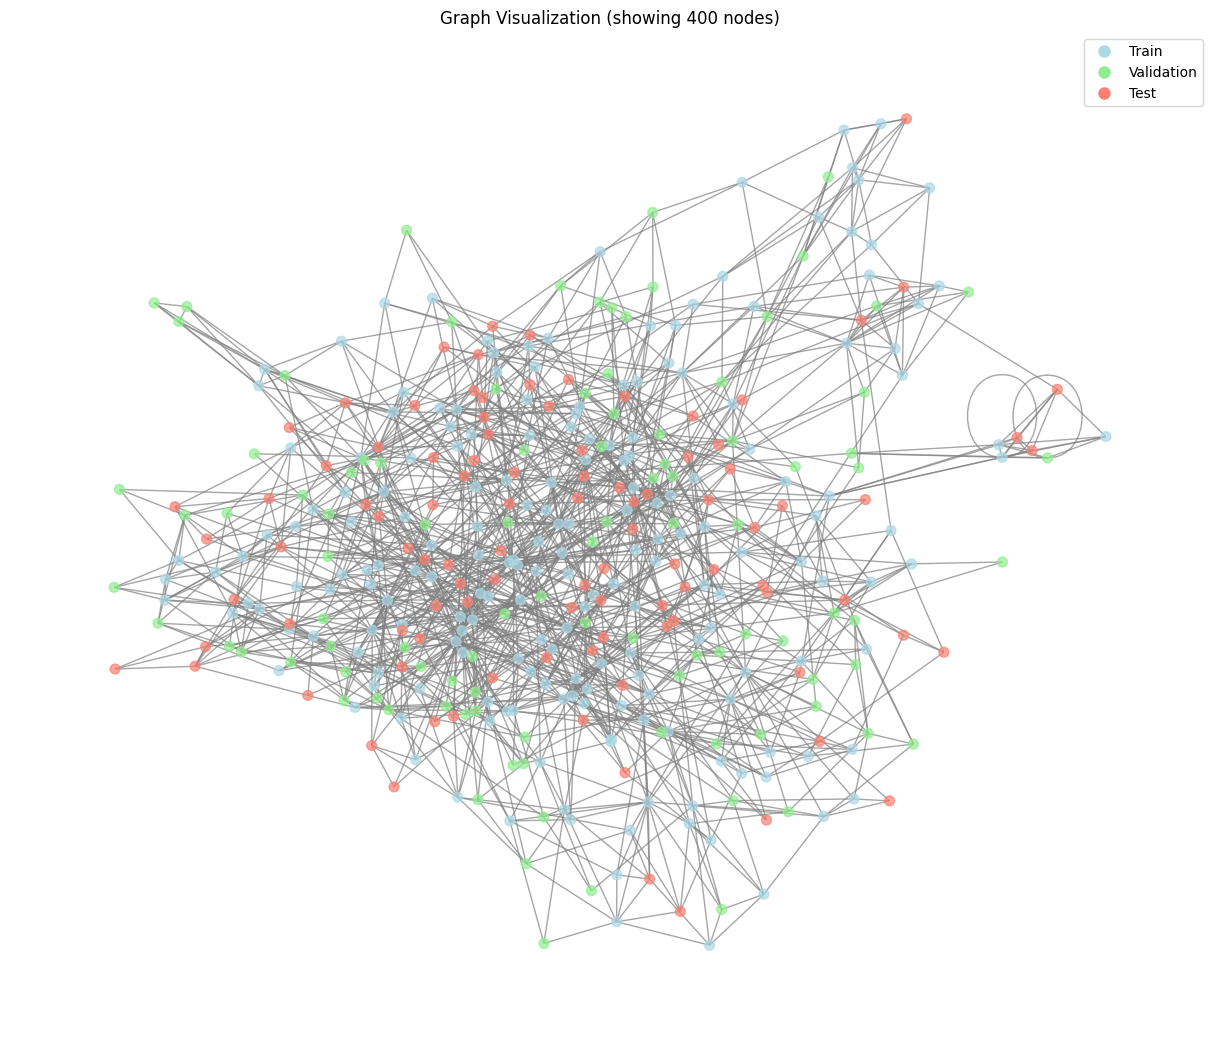

In [65]:
# Call the function
visualize_graph(graph, show_num_nodes=500)

# TSNE Distribution

x shape: torch.Size([400, 768])
y shape: torch.Size([400])


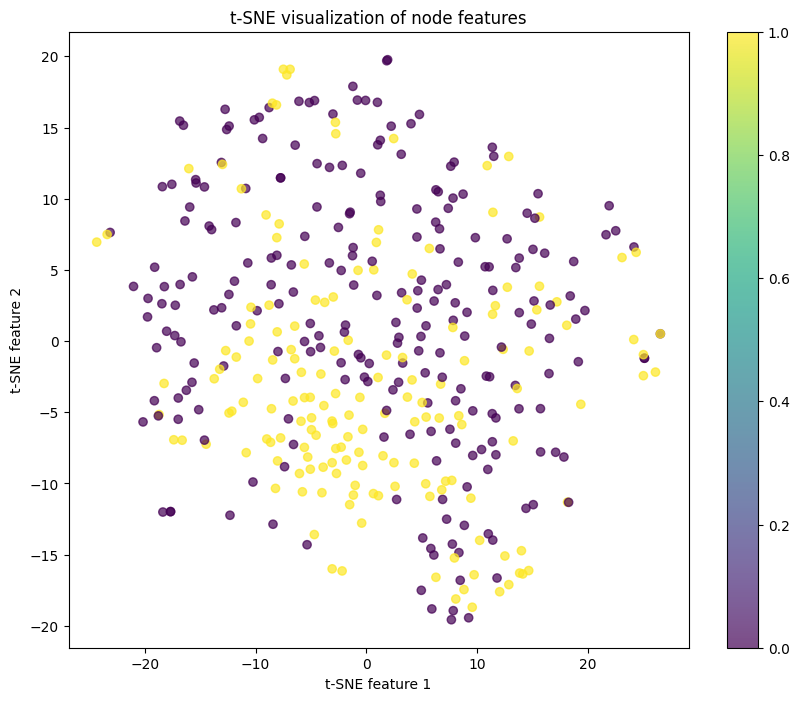

In [71]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(x, y, title="t-SNE visualization of node features"):
    print(f"x shape: {x.shape}")
    print(f"y shape: {y.shape}")
    
    # Convert to numpy arrays
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    x_tsne = tsne.fit_transform(x_np)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_np, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

# Assuming graph_data is your graph data object
plot_tsne(graph_data.x, graph_data.y)

# GCN

In [66]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [67]:
# Train the GCN
model = GCN(in_channels=graph_data.num_features, hidden_channels=16, out_channels=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

accuracy_record = []
loss_record = []

# Train the model
for epoch in range(1, 201):
    loss = train(graph_data)
    acc = test(graph_data)
    accuracy_record.append(acc)
    loss_record.append(loss.item())
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Acc: {acc:.4f}')

# Evaluate the model
test_acc = test(graph_data)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1, Loss: 0.6712, Acc: 0.6200
Epoch 2, Loss: 0.7811, Acc: 0.3800
Epoch 3, Loss: 1.1208, Acc: 0.4100
Epoch 4, Loss: 0.7221, Acc: 0.6200
Epoch 5, Loss: 0.6717, Acc: 0.6200
Epoch 6, Loss: 0.8329, Acc: 0.6200
Epoch 7, Loss: 0.7364, Acc: 0.7000
Epoch 8, Loss: 0.5805, Acc: 0.5600
Epoch 9, Loss: 0.5994, Acc: 0.4700
Epoch 10, Loss: 0.6812, Acc: 0.5000
Epoch 11, Loss: 0.6492, Acc: 0.6500
Epoch 12, Loss: 0.5625, Acc: 0.6800
Epoch 13, Loss: 0.5387, Acc: 0.7100
Epoch 14, Loss: 0.5764, Acc: 0.7100
Epoch 15, Loss: 0.5975, Acc: 0.7100
Epoch 16, Loss: 0.5708, Acc: 0.6700
Epoch 17, Loss: 0.5273, Acc: 0.6400
Epoch 18, Loss: 0.5120, Acc: 0.6400
Epoch 19, Loss: 0.5293, Acc: 0.6300
Epoch 20, Loss: 0.5430, Acc: 0.6400
Epoch 21, Loss: 0.5288, Acc: 0.6500
Epoch 22, Loss: 0.5015, Acc: 0.6700
Epoch 23, Loss: 0.4886, Acc: 0.6700
Epoch 24, Loss: 0.4954, Acc: 0.6800
Epoch 25, Loss: 0.5028, Acc: 0.6800
Epoch 26, Loss: 0.4952, Acc: 0.6900
Epoch 27, Loss: 0.4772, Acc: 0.6600
Epoch 28, Loss: 0.4654, Acc: 0.6400
E

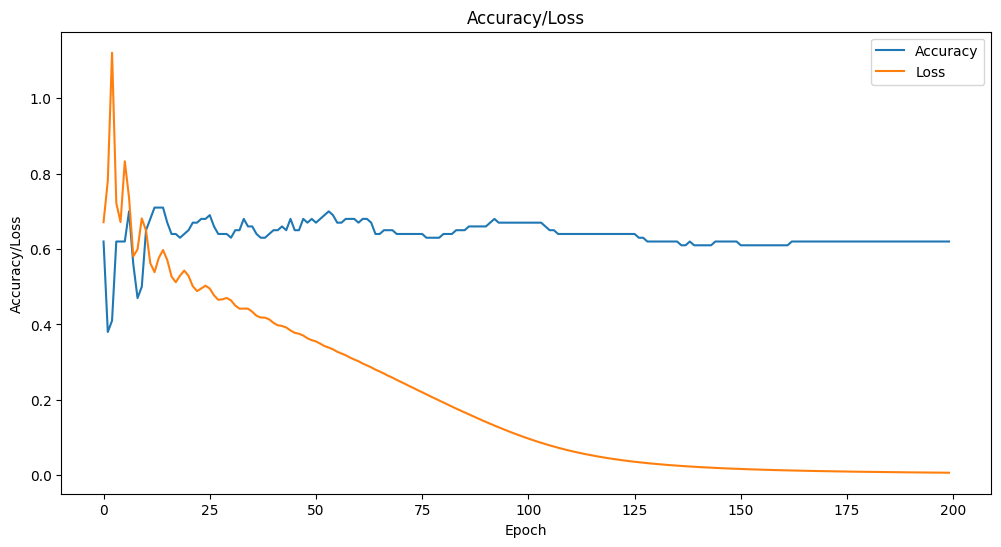

In [68]:
# plot the accuracy and loss at same plot
plt.figure(figsize=(12, 6))
plt.plot(accuracy_record, label='Accuracy')
plt.plot(loss_record, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Accuracy/Loss')
plt.legend()
plt.show()

x shape: torch.Size([400, 2])
y shape: torch.Size([400])


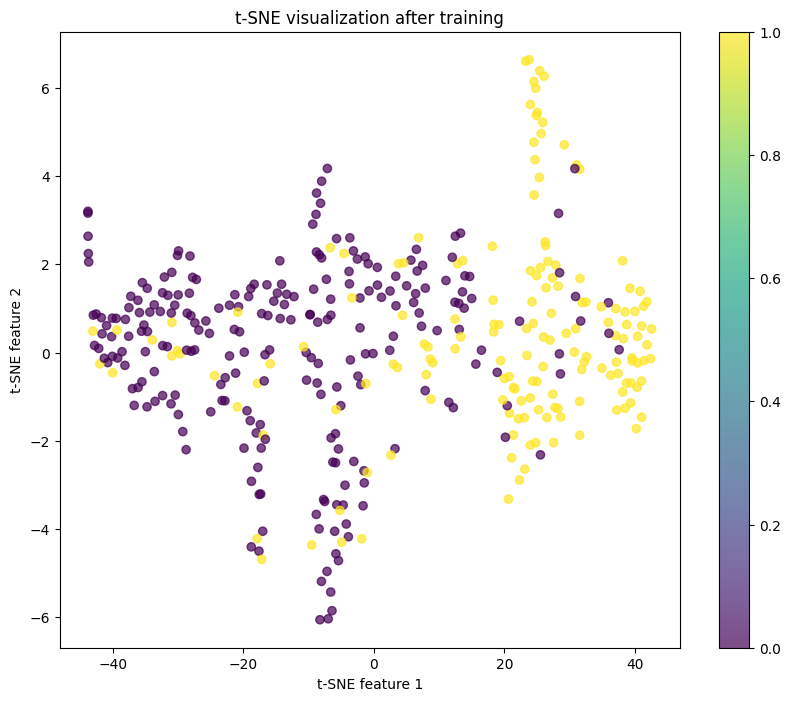

In [72]:
# Assuming you've already trained your model
model.eval()
with torch.no_grad():
    transformed_features = model(graph_data)

plot_tsne(transformed_features, graph_data.y, "t-SNE visualization after training")